## Домашнее задание по теме "Последовательное тестирование"В этом домашнем задании ты применишь инструменты последовательного тестирования для анализа результатов A/B тестирования. Данный датасет уже использовался на семинаре, но на всякий случай продублируем его описание:*В данном исследовании необходимо проанализировать результаты A/B-теста, проведенного онлайн-магазином. Компания разработала новый дизайн веб-страниц, чтобы попытаться увеличить количество пользователей, которые «конвертируются», то есть количество пользователей, которые решают заплатить за продукт компании. Ваша цель -- проанализировать представленные данные, чтобы помочь компании понять, следует ли им внедрять эту новую страницу, сохранять старую страницу или, возможно, проводить эксперимент дольше, чтобы принять решение.*После семинара (внезапно!) оказалось, что о каждом пользователе можно найти дополнительную информацию - страна, в которой он находится! Поскольку столь важную информацию не хочется оставлять без внимания, придется использовать её в домашней работе.В этом домашнем задании нам понадобятся два файла:__ab_data.csv__ - файл, содержащий информацию о конверсии пользователей (с этим датасетом мы работали на семинаре).  __countries.csv__ - файл, содержащий информацию о стране.Сначала прочитаем эти файлы и создадим один датафрейм:在这个研究中，您需要分析在线商店进行的A/B测试结果。公司开发了一个新的网页设计，以尝试增加“转化”用户的数量，也就是那些决定为公司产品付费的用户数量。您的目标是分析给定的数据，以帮助公司了解是否应该采用新页面，保留旧页面，或者可能需要进行更长时间的实验以做出决定。在研讨会之后（突然！）发现每个用户还有更多的额外信息——他们所在的国家！由于这些信息非常重要，所以我们需要在这个家庭作业中使用它。任务说明:为了完成这个家庭作业，我们需要两个文件：ab_data.csv — 包含用户转化信息的文件（这个数据集在研讨会上已经使用过）。countries.csv — 包含用户所在国家信息的文件。

In [1]:
import pandas as pd
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1bLhznTSMaIcDFF-DQ7xUNofYfS-duwn7').sort_values('timestamp')
df = df.drop_duplicates(subset='user_id', keep=False)
cities = pd.read_csv('https://drive.google.com/uc?export=download&id=1bCFK7r-XWqBx_Dem7hLqTMIfskCsrXho')
df = df.merge(cities, on='user_id', how='inner')
df.head(10)


,user_id,timestamp,group,landing_page,converted,city
0,922696,2017-01-02 13:42:05.378582,treatment,new_page,0,Moscow
1,781507,2017-01-02 13:42:15.234051,control,old_page,0,Saint-Petersburg
2,737319,2017-01-02 13:42:21.786186,control,old_page,0,Moscow
3,818377,2017-01-02 13:42:26.640581,treatment,new_page,0,Moscow
4,725857,2017-01-02 13:42:27.851110,treatment,new_page,0,Moscow
5,762651,2017-01-02 13:42:28.522322,treatment,new_page,0,Moscow
6,722516,2017-01-02 13:42:34.033708,treatment,new_page,0,Moscow
7,688937,2017-01-02 13:42:41.406986,treatment,new_page,0,Moscow
8,781125,2017-01-02 13:42:45.090432,treatment,new_page,0,Moscow
9,799109,2017-01-02 13:42:45.219901,control,old_page,0,Moscow


Напомним, что в данном датасете есть следующие поля:**user_id** -- уникальный id пользователя (каждый пользователь встречается лишь один раз)  **timestamp** -- время, когда пользователь открыл страницу  **group** -- группа, к которой относится пользователь  **landing_page** -- какой тип страницы был показан пользователю (контрольным пользователям всегда показывается старая страница, тестовым - новая)  **converted** -- информация о том, произошла ли конверсия пользователя  **city** -- город пользователя
user_id — 用户的唯一ID（每个用户只出现一次）
timestamp — 用户打开页面的时间
group — 用户所属的组
landing_page — 展示给用户的页面类型（控制组用户始终看到旧页面，测试组用户看到新页面）
converted — 用户是否发生了转化
city — 用户所在的城市

In [2]:
df['city'].value_counts()

city
Moscow              200875
Saint-Petersburg     71513
Novosibirsk          14303
Name: count, dtype: int64

In [3]:
# 检查每个城市控制组的数据量
control_counts = df[df['group'] == 'control']['city'].value_counts()

# 打印结果
print(control_counts)


city
Moscow              100316
Saint-Petersburg     35883
Novosibirsk           7094
Name: count, dtype: int64


# Задание 1. (2.5 балла)Для пользователей контрольной группы каждого города по отдельности при помощи классического SPRT города проверь следующие гипотезы:- H0: уровень конверсии составляет 10%.  - H1: уровень конверсии составляет 12%.  Построй графики значения статистики lambda на каждом шаге. 1）Возьми alpha = 0.1 и beta = 0.1 Проанализируй данные графики и сделайте выводы по каждому из городов分析每个城市的图形，并根据图表做出结论.


City: Moscow, Total Samples (used): 100316
City: Saint-Petersburg, Total Samples (used): 35883
City: Novosibirsk, Total Samples (used): 7094


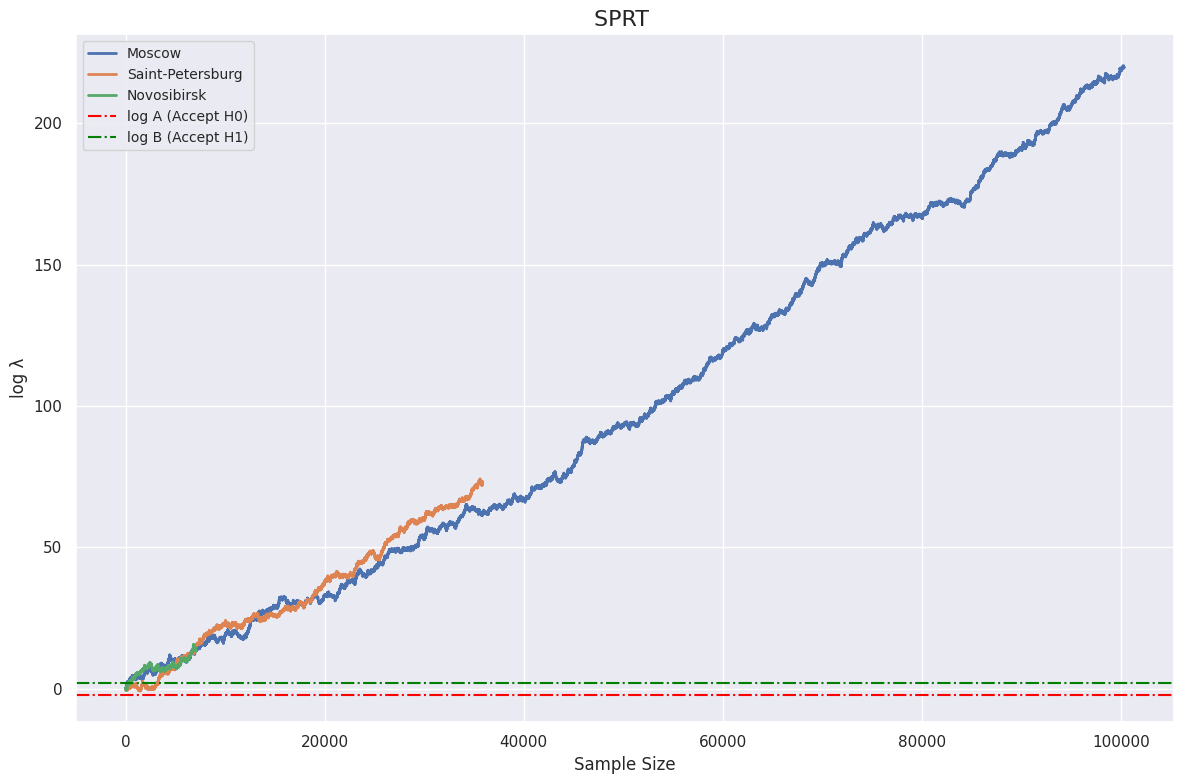

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")  # 使用 seaborn 样式

# SPRT 核心函数
def sprt(count, nobs, p0, p1, alpha=0.1, beta=0.1):
    A = beta / (1 - alpha)
    B = (1 - beta) / alpha
    ratio = np.exp(count * np.log(p1 / p0) + (nobs - count) * np.log((1 - p1) / (1 - p0)))
    if ratio <= A:
        return ratio, "H0"
    elif ratio >= B:
        return ratio, "H1"
    return ratio, "None"

# 假设定义
p0 = 0.10
p1 = 0.12
alpha = 0.1
beta = 0.1

# 绘图设置
plt.figure(figsize=(12, 8))
cities = df['city'].unique()

# 限制绘制样本数量
max_samples = 100316

for city in cities:
    city_data = df[(df['city'] == city) & (df['group'] == 'control')]['converted'][:max_samples]

    print(f"City: {city}, Total Samples (used): {len(city_data)}")

    sprt_values = []
    for i in range(1, len(city_data) + 1):
        count = city_data.iloc[:i].sum()
        nobs = i
        ratio, decision = sprt(count, nobs, p0, p1, alpha, beta)
        log_lambda = np.log(ratio)  # 计算 log(λ)
        sprt_values.append(log_lambda)

    # 横轴为样本大小，纵轴为 log(λ)
    sample_sizes = range(1, len(city_data) + 1)

    # 绘制曲线
    plt.plot(
        sample_sizes,
        sprt_values,
        label=f'{city}',
        linewidth=2
    )

# 添加 log(A) 和 log(B) 的阈值线
log_A = np.log(beta / (1 - alpha))
log_B = np.log((1 - beta) / alpha)
plt.axhline(y=log_A, color='red', linestyle='-.', label='log A (Accept H0)')
plt.axhline(y=log_B, color='green', linestyle='-.', label='log B (Accept H1)')

# 图表美化
plt.title('SPRT ', fontsize=16)
plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('log λ', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


**Выводы по графикам:Три города отклоняют нулевую гипотезу H0и принимают альтернативную гипотезуH1, что их уровень конверсии может быть выше (ближе к 12%).

# Задание 2.  (2.5 балла)При помощи mSPRT, сравни уровни конверсий пользователей контрольной группы в разных городах. Возьми tau_sq = 0.001 и alpha = 0.05. построй графики p-value. Сделай выводы.

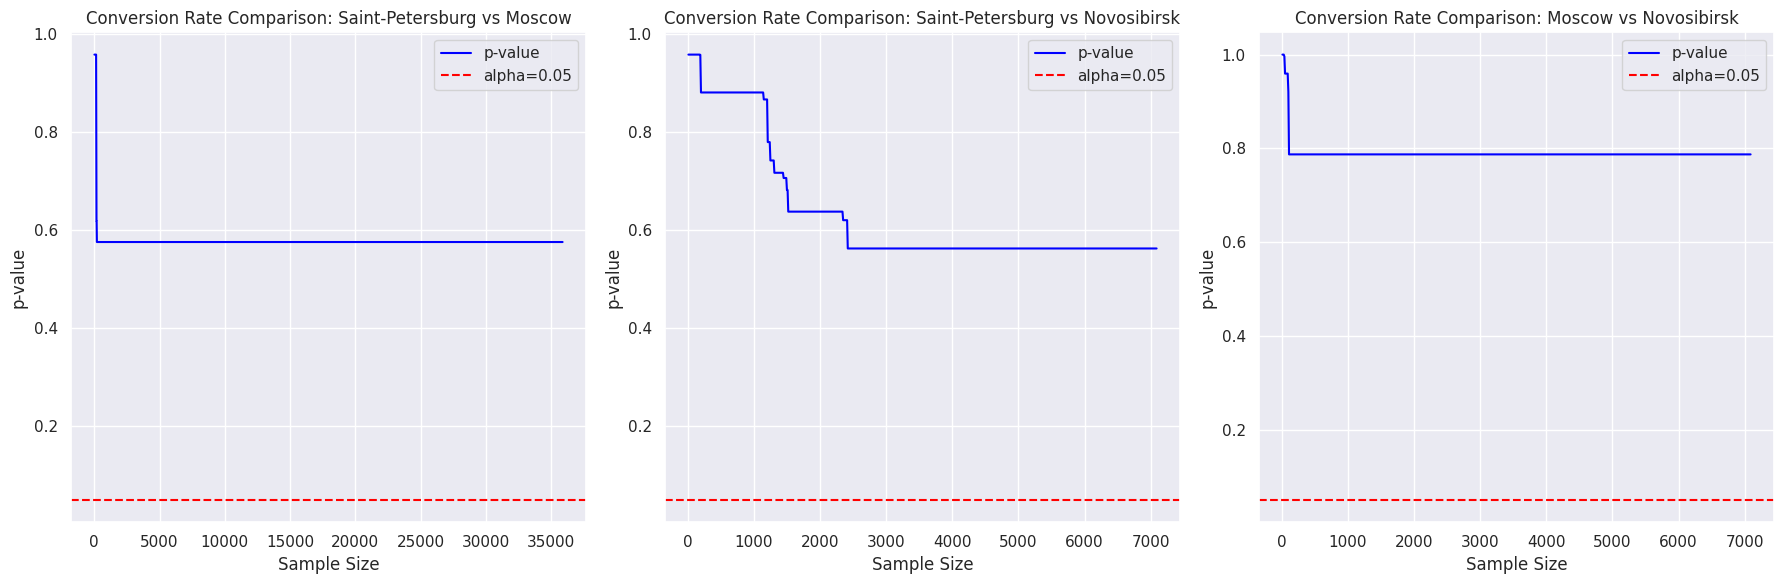

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import norm

# Function to compute lambda (log-likelihood ratio)
def lambda_function(n, mu_a, mu_b, tau_sq):
    v_n = (mu_a * (1 - mu_a) + mu_b * (1 - mu_b))
    nts = n * tau_sq
    if v_n == 0:
        return 1.0
    else:
        return (np.sqrt(v_n / (v_n + nts)) *
                np.exp(((n * nts) * (mu_a - mu_b)**2) /
                       ((2.0 * v_n) * (v_n + nts))))




def valid_p_value(a_obs, b_obs, tau_sq=0.001):
    mu_a = a_obs.mean()
    mu_b = b_obs.mean()
    return min(1, 1 / lambda_function(len(a_obs), mu_a, mu_b, tau_sq))

# Process control group data
control_data = df[df['group'] == 'control']
cities = control_data['city'].unique()

# Generate city combinations
city_combinations = list(combinations(cities, 2))

# Plot p-value for each city pair
plt.figure(figsize=(18, 6))
for i, (city1, city2) in enumerate(city_combinations, 1):
    data1 = control_data[control_data['city'] == city1]['converted'].reset_index(drop=True)
    data2 = control_data[control_data['city'] == city2]['converted'].reset_index(drop=True)

    # Initialize p-value list
    p_values = []
    p_value = 1.0  # Start with p-value = 1

    # Compute p-value iteratively
    for n in range(10, min(len(data1), len(data2)), 10):
        p_value = min(p_value, valid_p_value(data1[:n], data2[:n], tau_sq=0.001))
        p_values.append(p_value)

    # Plot each comparison
    plt.subplot(1, len(city_combinations), i)
    plt.plot(range(10, 10 * len(p_values) + 1, 10), p_values, label='p-value', color='blue')
    plt.axhline(y=0.05, color='red', linestyle='--', label='alpha=0.05')
    plt.title(f"Conversion Rate Comparison: {city1} vs {city2}")
    plt.xlabel("Sample Size")
    plt.ylabel("p-value")
    plt.legend()

plt.tight_layout()
plt.show()


Невозможно отклонить нулевую гипотезу, возможно, различия между городами незначительны.

# Задание 3.  (2.5 балла)При помощи mSPRT, оцени влияние нового дизайна на пользователей в разных городах. Возьми tau_sq = 0.001 и alpha = 0.05. Построй графики p-value. Сделай выводы.

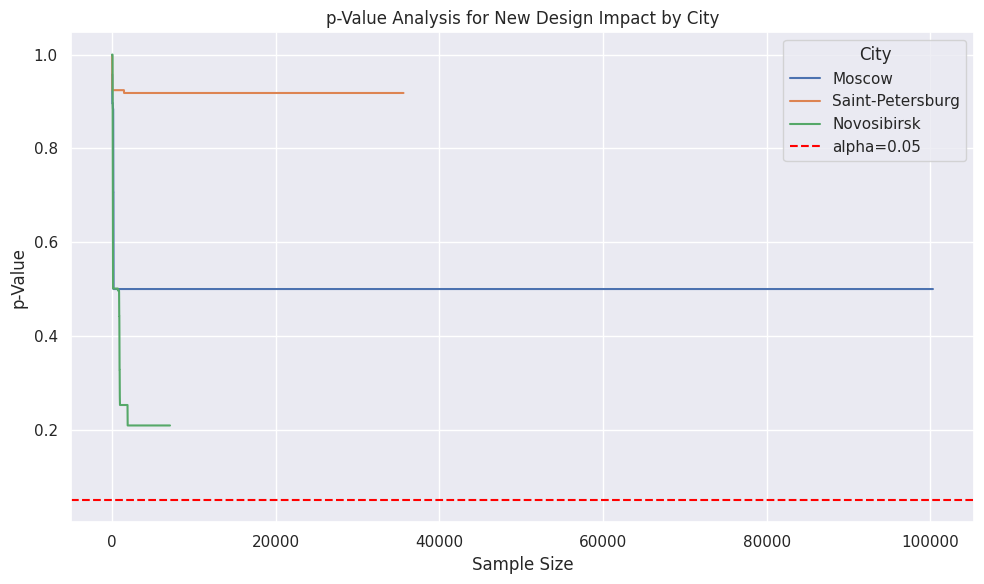

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Lambda 函数计算
def lambda_function(n, mu_a, mu_b, tau_sq):
    v_n = (mu_a * (1 - mu_a) + mu_b * (1 - mu_b))
    nts = n * tau_sq
    if v_n == 0:
        return 1.0
    else:
        return (np.sqrt(v_n / (v_n + nts)) *
                np.exp(((n * nts) * (mu_a - mu_b)**2) /
                       ((2.0 * v_n) * (v_n + nts))))

# p-value 计算函数
def valid_p_value(a_obs, b_obs, tau_sq=0.001):
    mu_a = a_obs.mean()
    mu_b = b_obs.mean()
    return min(1, 1 / lambda_function(len(a_obs), mu_a, mu_b, tau_sq))
# 筛选数据
control_data = df[df['landing_page'] == 'old_page']  # old_page
treatment_data = df[df['landing_page'] == 'new_page']  # new_page
cities = df['city'].unique()  # 获取所有城市

# 设置绘图
plt.figure(figsize=(10, 6))

# 针对每个城市，计算 p-value 曲线
for city in cities:
    # 获取每个城市的 old_page 和 new_page 数据
    control_city = control_data[control_data['city'] == city]['converted'].reset_index(drop=True)
    treatment_city = treatment_data[treatment_data['city'] == city]['converted'].reset_index(drop=True)
    
    # 初始化 p-value 列表
    p_values = []
    p_value = 1.0  # 初始 p-value = 1
    
    # 根据样本量计算逐步更新的 p-value
    for n in range(10, min(len(control_city), len(treatment_city)), 10):
        p_value = min(p_value, valid_p_value(control_city[:n], treatment_city[:n], tau_sq=0.001))
        p_values.append(p_value)
    
    # 绘制每个城市的 p-value 曲线
    plt.plot(range(10, 10 * len(p_values) + 1, 10), p_values, label=f"{city}")

# 添加显著性水平线
plt.axhline(y=0.05, color='red', linestyle='--', label='alpha=0.05')

# 图形美化
plt.title("p-Value Analysis for New Design Impact by City")
plt.xlabel("Sample Size")
plt.ylabel("p-Value")
plt.legend(title="City")
plt.grid(True)
plt.tight_layout()
plt.show()


**Выводы по графикам: Невозможно отклонить нулевую гипотезу,эффект нового дизайна может быть незначительным в разных городах.**

# Задание 4  (2.5 балла)Примените метод из блогпоста Эвана Миллера для оценки конверсии в каждом из городов. Возьмите MDE = 25%, alpha = 5% и beta = 15%. Для данных значений найдите необходимое число успехов и максимальное число конверсий, постройте графики по каждому из городов и сделайте выводы.

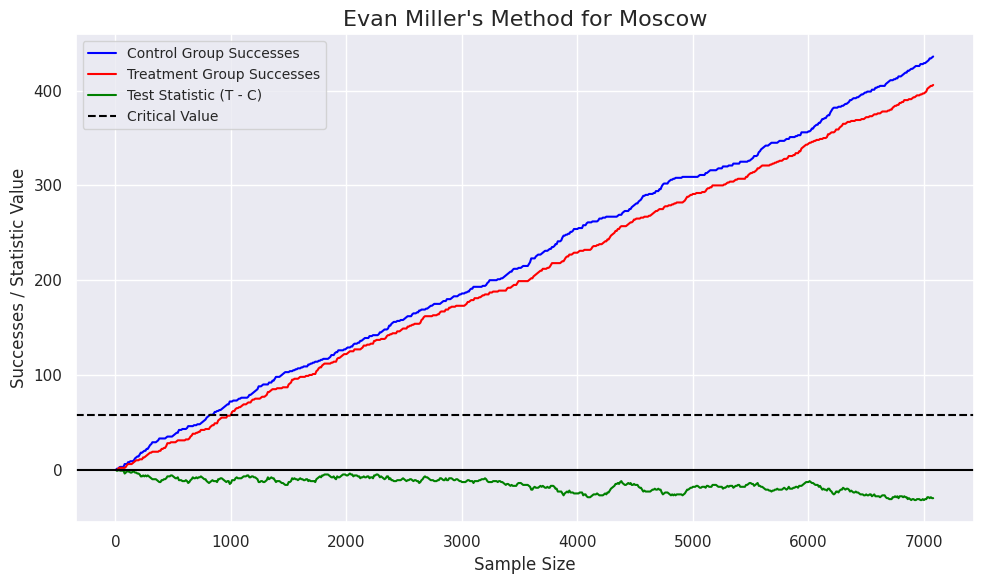

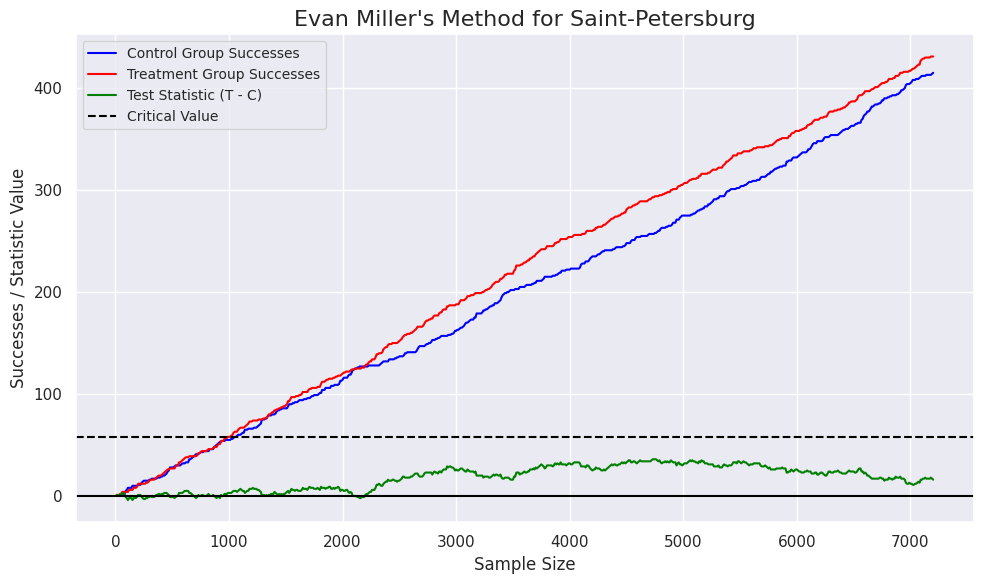

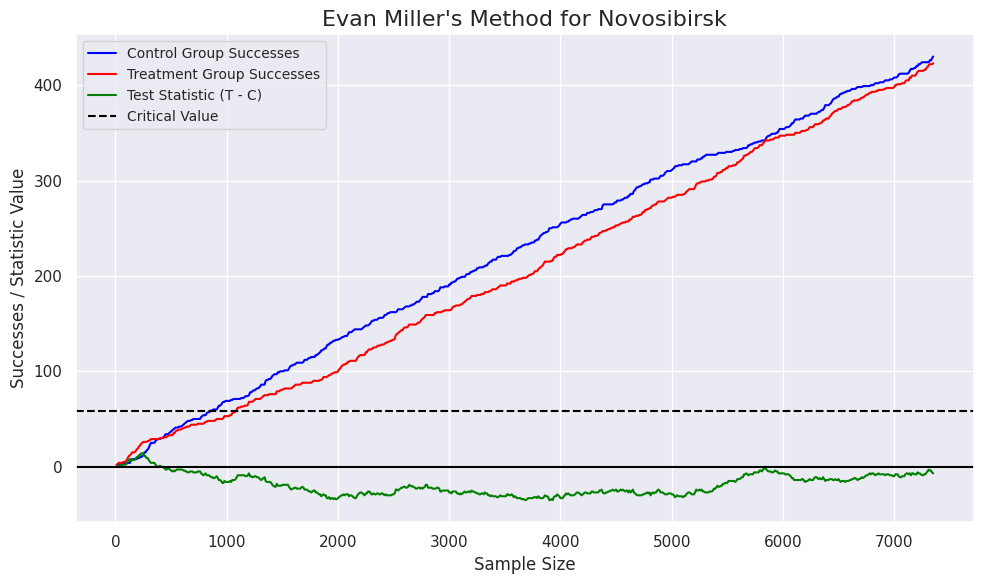

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import sqrt

# Evan Miller 方法的评分函数
def score(T, C, N):
    if T - C >= 2 * sqrt(N):
        return 'There is an effect'
    if T + C >= N:
        return 'There is no effect'
    return None

# 参数设置
MDE = 0.25
alpha = 0.05
beta = 0.15

# 计算所需样本量的函数
def calculate_required_sample_size(p, alpha, beta, MDE):
    z_alpha = norm.ppf(1 - alpha)
    z_beta = norm.ppf(1 - beta)
    delta = p * MDE
    return ((z_alpha + z_beta)**2 * p * (1 - p)) / (delta**2)

# 按城市分析
cities = df['city'].unique()

for city in cities:
    city_data = df[df['city'] == city]
    control_data = city_data[(city_data['group'] == 'control') & (city_data['landing_page'] == 'old_page')]
    treatment_data = city_data[(city_data['group'] == 'treatment') & (city_data['landing_page'] == 'new_page')]

    # 计算转化率和样本需求
    control_conv_rate = control_data['converted'].mean()
    N = calculate_required_sample_size(control_conv_rate, alpha, beta, MDE)

    control_successes = []
    treatment_successes = []
    test_statistics = []
    for i in range(10, city_data.shape[0] + 1, 10):  # 处理所有样本，步长为10
        data = city_data.head(i)
        T = data[data['group'] == 'treatment']['converted'].sum()
        C = data[data['group'] == 'control']['converted'].sum()
        control_successes.append(C)
        treatment_successes.append(T)
        test_statistics.append(T - C)
        if score(T, C, N) is not None:
            break

    # 绘制图表
    plt.figure(figsize=(10, 6))
    sample_sizes = [i * 10 for i in range(1, len(control_successes) + 1)]
    plt.plot(sample_sizes, control_successes, color="blue", label="Control Group Successes")
    plt.plot(sample_sizes, treatment_successes, color="red", label="Treatment Group Successes")
    plt.plot(sample_sizes, test_statistics, color="green", label="Test Statistic (T - C)")

    # 添加关键值线
    plt.axhline(y=2 * sqrt(N), color='black', linestyle='--', label="Critical Value")
    plt.axhline(y=0, color='black', linestyle='-')
    #plt.axhline(y=-2 * sqrt(N), color='black', linestyle='--', label="Critical Value (-)")

    # 图表设置
    plt.title(f"Evan Miller's Method for {city}", fontsize=16)
    plt.xlabel("Sample Size", fontsize=12)
    plt.ylabel("Successes / Statistic Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Зеленая линия не пересекает черную пунктирную линию, следовательно, мы не можем отклонить нулевую гипотезу (то есть эффект нового дизайна не является значимым).